# Homework 4
**Date:** 3/12/2024

## Introduction

In this report we will combine phone usage data with population data to calculate the number of cell phones per capita for various countries over the years. Additionally, we perform SQL queries on a user actions database and utilize regular expressions to extract information from user comments.

---

## Joining Data
We will analyze the number of phones per capita across different countries over the years. By combining cell phone data, population data, and country information, Specifically. Then we'll analyze our data, we'll focus on countries with the highest number of phones per capita in recent years.


### Data Preparation

We will use the following datasets:

- **`pop_data.csv`**: Population data for countries from 1960 to 2020.
- **`cell_phones_total.csv`**: Total number of cell phones per country from 1960 to 2019. The file with cleaned data from Homework 3. Where we for the first year set all missing values to $0$ and then forward filled any missing data. 
- **`country_data.csv`**: Mapping between ISO-3 country codes and country names.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
pop_data = pd.read_csv('pop_data.csv')
cell_data = pd.read_csv('cell_phones_total.csv')
country_data = pd.read_csv('country_data.csv')

### 1.1 Handling Missing Values
We inspect the population data before proceeding to understand the structure and the missing values.

In [2]:
pop_data.head()

,Unnamed: 0,iso-3,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,...,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0
1,1,AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,...,537792950.0,552530654.0,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0
2,2,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,...,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0
3,3,AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,...,366489204.0,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0
4,4,AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,...,24259111.0,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0


In [3]:
pop_data.info()
# Show rows with missing values and which columns have missing data
rows_with_missing = pop_data[pop_data.isna().any(axis=1)]
print(rows_with_missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  266 non-null    int64  
 1   iso-3       266 non-null    object 
 2   1960        264 non-null    float64
 3   1961        264 non-null    float64
 4   1962        264 non-null    float64
 5   1963        264 non-null    float64
 6   1964        264 non-null    float64
 7   1965        264 non-null    float64
 8   1966        264 non-null    float64
 9   1967        264 non-null    float64
 10  1968        264 non-null    float64
 11  1969        264 non-null    float64
 12  1970        264 non-null    float64
 13  1971        264 non-null    float64
 14  1972        264 non-null    float64
 15  1973        264 non-null    float64
 16  1974        264 non-null    float64
 17  1975        264 non-null    float64
 18  1976        264 non-null    float64
 19  1977        264 non-null    f

We check the data and see that in the population data that one country ('INX') is missing values for all years. We will replace that countries population for all years with $0$. Another country ('PSE') is missing half of the country data. Replace the values using linear interpolation, since country population should be almost always increasing.

In [4]:
# Get the list of year columns 
years_cols = [col for col in pop_data.columns if col != 'iso-3']

# Replace 'INX' population data with zeros
pop_data.loc[pop_data['iso-3'] == 'INX', years_cols] = 0

# For 'PSE', interpolate missing values across years
pop_data.loc[pop_data['iso-3'] == 'PSE', years_cols] = \
    pop_data.loc[pop_data['iso-3'] == 'PSE', years_cols].interpolate(axis=1, limit_direction='both')

# Remove the first columns which are index
pop_data = pop_data.drop(pop_data.columns[0], axis=1)


### 1.2 Reshaping the Data

We need to reshape both datasets from wide to long format for merging.


In [5]:
# Reshape phone data to long format
cell_long = cell_data.melt(id_vars=['iso-3'], var_name='year', value_name='n_cellphones')

# Reshape population data
pop_long = pop_data.melt(id_vars=['iso-3'], var_name='year', value_name='population')

# Convert year to integer
pop_long['year'] = pop_long['year'].astype(int)
cell_long['year'] = cell_long['year'].astype(int)
pop_long.head()

,iso-3,year,population
0,ABW,1960,54608.0
1,AFE,1960,130692579.0
2,AFG,1960,8622466.0
3,AFW,1960,97256290.0
4,AGO,1960,5357195.0



### 1.3 Merging the Data

Merge the population and cell phone datasets based on `iso-3` and `year`.


In [6]:
# Merge the datasets
merged_data = pd.merge(cell_long, pop_long, on=['iso-3', 'year'], how='inner')
merged_data.head()

,iso-3,year,n_cellphones,population
0,CHN,1960,0.0,667070000.0
1,IND,1960,0.0,445954579.0
2,USA,1960,0.0,180671000.0
3,IDN,1960,0.0,88382881.0
4,BRA,1960,0.0,73092515.0



### 1.4 Adding Country Names

We inspect country data:

In [7]:
country_data.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In the `country_data` we have a variable "alpha-3" which is the equivalen to "iso-3" and "names". We will merge those country names to our data. 

In [8]:
# Prepare country data
country_names = country_data[['alpha-3', 'name']].rename(columns={'alpha-3': 'iso-3'})

# Merge with merged_data
merged_data = pd.merge(merged_data, country_names, on='iso-3', how='left')

merged_data.head()

,iso-3,year,n_cellphones,population,name
0,CHN,1960,0.0,667070000.0,China
1,IND,1960,0.0,445954579.0,India
2,USA,1960,0.0,180671000.0,United States of America
3,IDN,1960,0.0,88382881.0,Indonesia
4,BRA,1960,0.0,73092515.0,Brazil



### 1.5 Calculating Phones per Capita

We calculate the number of phones per capita. Anywhere where population data is $0$ we set the per capita to $0$ as well (it's only INX).


In [9]:
# Compute phones_per_capita, setting it to zero where population is zero
merged_data['phones_per_capita'] = np.where(
    merged_data['population'] == 0,
    0,
    merged_data['n_cellphones'] / merged_data['population']
)
merged_data.head()

,iso-3,year,n_cellphones,population,name,phones_per_capita
0,CHN,1960,0.0,667070000.0,China,0.0
1,IND,1960,0.0,445954579.0,India,0.0
2,USA,1960,0.0,180671000.0,United States of America,0.0
3,IDN,1960,0.0,88382881.0,Indonesia,0.0
4,BRA,1960,0.0,73092515.0,Brazil,0.0



### 1.6 Presenting the Data

Extract the top countries with the highest number of cell phones per capita in 2019 and present the data with recent years.


In [10]:
# Filter data for 2019
data_2019 = merged_data[merged_data['year'] == 2019]

# Get top 5 countries by phones_per_capita
top_countries_2019 = data_2019.sort_values(by='phones_per_capita', ascending=False).head(5)

# Get country names
top_country_names = top_countries_2019['name'].tolist()

# Filter merged_data for top countries and recent years (2015-2019)
filtered_data = merged_data[
    (merged_data['year'] >= 2015) &
    (merged_data['name'].isin(top_country_names))
]

# Pivot the table
pivot_table = filtered_data.pivot(index='year', columns='name', values='phones_per_capita')

# Reset the index to convert 'year' from index to a column
pivot_table = pivot_table.reset_index()

# Remove the columns' name
pivot_table.columns.name = None

# Ensure the columns are in the desired order
pivot_table = pivot_table[['year'] + top_country_names]

# Round the values 
pivot_table[top_country_names] = pivot_table[top_country_names].round(5)

# Display the table
pivot_table

,year,Macao,Hong Kong,United Arab Emirates,Antigua and Barbuda,Seychelles
0,2015,3.08823,2.29040,2.00742,1.95684,1.58426
1,2016,3.14351,2.39893,2.21252,1.98754,1.60546
2,2017,3.21010,2.48877,2.18343,2.01934,1.74243
3,2018,3.34874,2.67021,2.19908,2.00816,1.84990
4,2019,3.28485,2.86365,2.12774,1.99746,1.98720



### 1.7 Growth Rate Analysis

We plot the growth rate of phones per capita over the last 10 years for the top countries from our previous table.




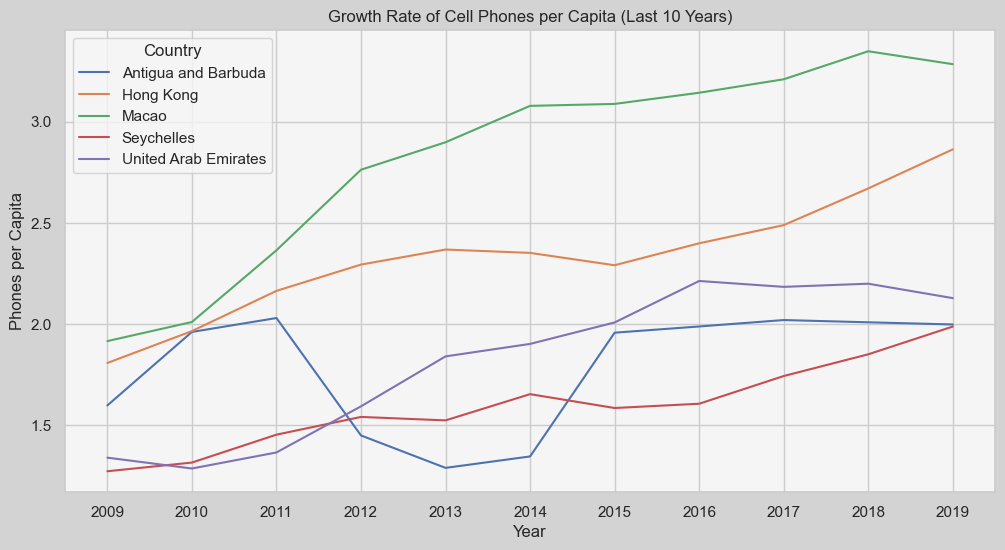

In [11]:
# Filter data for the last 10 years
last_10_years = merged_data[
    (merged_data['year'] >= 2009) &
    (merged_data['name'].isin(top_country_names))
]

# Background
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "whitesmoke", "figure.facecolor": "lightgray"})

# Pivot data for plotting
plot_data = last_10_years.pivot(index='year', columns='name', values='phones_per_capita')

# Plot the data
plot_data.plot(figsize=(12, 6))
plt.xticks(ticks=range(plot_data.index.min(), plot_data.index.max() + 1))
plt.title('Growth Rate of Cell Phones per Capita (Last 10 Years)')
plt.ylabel('Phones per Capita')
plt.xlabel('Year')
plt.legend(title='Country')
plt.show()

This diagram illustrates the growth in cell phones per capita over a 10-year period across five countries. 

1. **Macao** consistently has the highest growth rate, reaching over 3 phones per capita by the end of the period.
2. **Hong Kong** shows steady growth throughout the years and maintains the second-highest rate by 2019.
3. **Seychelles** and **United Arab Emirates** show slower initial growth but experience a more pronounced increase after 2014, with Seychelles surpassing Antigua and Barbuda around 2015.
4. **Antigua and Barbuda** starts with relatively high numbers but exhibits the slowest growth, remaining below 2 phones per capita throughout the period.
5. The gap between countries widens significantly over time.


---

## 2. SQL Tasks

We will analyze the `user_actions` table in the `user_actions.db` SQLite database. We will retrieve the usernames of all users who performed the "signup" action and calculate the total log entries for each user, displaying the user_id, username, and log count. Additionally, identify users who completed both "login" and "signup" actions on the same day, showing their user_id and username.

### 2.1 Connecting to the Database


In [12]:
import sqlite3 as sql

# Connect to the SQLite database
conn = sql.connect('user_actions.db')

### 2.2 Inspecting the data

In [13]:
print(conn.execute("SELECT type, name FROM sqlite_master").fetchall())

[('table', 'user_actions')]


In [14]:
# Load the first few rows of the user_actions table
df_preview = pd.read_sql_query("SELECT * FROM user_actions LIMIT 100;", conn)

# Display the first few rows and summary information
df_preview.head(5)

,user_id,username,email,action,timestamp
0,34,user34,user34@email.com,signup,2015-02-04 14:38:47
1,28,user28,user28@email.com,signup,2015-03-09 11:55:33
2,27,user27,user27@email.com,login,2015-04-17 14:48:31
3,27,user27,user27@email.com,login,2015-04-21 13:22:14
4,27,user27,user27@email.com,reset_password,2015-04-25 16:30:15



### 2.3 Retrieve the usernames of all users who have performed the "signup" action.


In [15]:
# Define the SQL query
query_task1 = """
SELECT DISTINCT username
FROM user_actions
WHERE action = 'signup';
"""
# Execute the query and fetch results into a DataFrame
df_task1 = pd.read_sql_query(query_task1, conn)

# Display the DataFrame
df_task1.head()

,username
0,user34
1,user28
2,user1
3,user24
4,user15



### 2.4 Find the total number of log entries for each user.


In [16]:
# Define the SQL query
query_task2 = """
SELECT user_id, username, COUNT(*) as total_login_entries
FROM user_actions
WHERE action = 'login'
GROUP BY user_id, username
ORDER BY user_id ASC; 
"""

# Execute the query and fetch results into a DataFrame
df_task2 = pd.read_sql_query(query_task2, conn)

# Display the DataFrame
df_task2.head()

,user_id,username,total_login_entries
0,1,user1,97
1,2,user2,139
2,3,user3,101
3,4,user4,425
4,5,user5,182



### 2.5. Identify users who have both logged in and signed up on the same day.



In [17]:
# Define the SQL query
query_task3 = """
SELECT DISTINCT ua1.user_id, ua1.username
FROM user_actions ua1
JOIN user_actions ua2 ON ua1.user_id = ua2.user_id
WHERE ua1.action = 'signup'
  AND ua2.action = 'login'
  AND DATE(ua1.timestamp) = DATE(ua2.timestamp);
"""

# Execute the query
df_task3 = pd.read_sql_query(query_task3, conn)

df_task3

,user_id,username
0,8,user8
1,12,user12
2,30,user30
3,7,user7
4,22,user22
5,5,user5
6,2,user2
7,32,user32


We close the file:

In [18]:
conn.close()


---

## 3. Regex Tasks

We will analyze `comments.txt` to extract hashtags and find specific patterns. We first open and inspect our file:


In [19]:
import pandas as pd
import re

# Load the file into a DataFrame
data_comments = pd.read_csv("comments.txt", header=None, names=["Line"])

# Display the first few rows
data_comments.head()

,Line
0,"1. ""Great post! #programming #tips"""
1,"2. ""Enjoyed the article. #coding #python"""
2,"3. ""Interesting insights. #tech #data"""
3,"4. ""This is awesome! #programming #coding"""
4,"5. ""Thanks for sharing. #data #analysis"""



### 3.1 Extract All Hashtags from a Comment

**Regular Expression:**
We create a regular expression and use it on the first comment in the file.

In [20]:
# Access the first line
first_line = data_comments.iloc[0, 0]  

# Extract hashtags using regex
hashtags = re.findall(r'#\w+', first_line) 

print(hashtags)

['#programming', '#tips']



### 3.2 Find Comments Mentioning Both "#programming" and "#python"
We create the regular expression and use it on the second comment.

**Regular Expression:**


In [21]:
regex_both = r'(?=.*#programming)(?=.*#python)' 

# Example comment
comment2 = data_comments.iloc[1, 0]

# Check if the comment matches
if re.search(regex_both, comment2):
    print("Comment mentions both #programming and #python.")
else:
    print("Comment does not mention both hashtags.")

Comment does not mention both hashtags.


### 3.3 Extract All Unique Hashtags from the File 

In [22]:
# Define regex to extract hashtags
regex_hashtags = r'#\w+'

# Concatenate all comments into a single string
all_comments = " ".join(data_comments["Line"])

# Find all hashtags in the comments
all_hashtags = re.findall(regex_hashtags, all_comments)

# Get unique hashtags
unique_hashtags = set(all_hashtags)

# Print unique hashtags
print(unique_hashtags)

{'#analysis', '#innovation', '#programming', '#python', '#data', '#research', '#analytics', '#coding', '#tech', '#insights', '#tips'}
